# SIFT

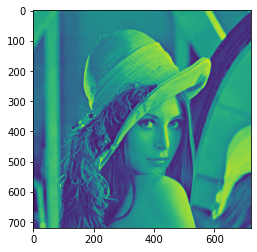

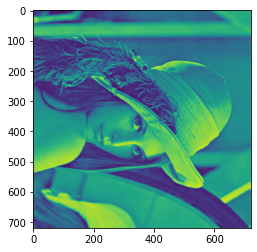

In [1]:
import matplotlib.pyplot as plt
import cv2


image1 = cv2.imread("lena.jpg", 0)
image2 = cv2.imread("lena-90.jpg", 0)

plt.figure()
plt.imshow(image1)
plt.savefig('image1.png', dpi=300)

plt.figure()
plt.imshow(image2)
plt.savefig('image2.png', dpi=300)

特征点提取&生成描述运行时间:0.97秒


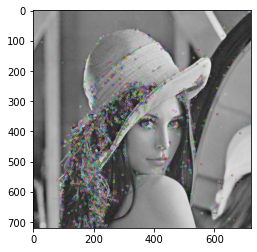

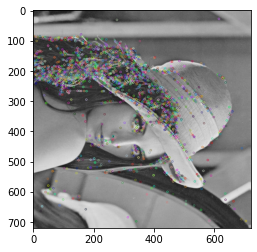

In [2]:
import time
#  计算特征点提取&生成描述时间
start = time.time()
sift = cv2.SIFT_create()
#  使用SIFT查找关键点key points和描述符descriptors
kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)
end = time.time()
print("特征点提取&生成描述运行时间:%.2f秒"%(end-start))

kp_image1 = cv2.drawKeypoints(image1, kp1, None)
kp_image2 = cv2.drawKeypoints(image2, kp2, None)

plt.figure()
plt.imshow(kp_image1)
plt.savefig('kp_image1.png', dpi = 300)

plt.figure()
plt.imshow(kp_image2)
plt.savefig('kp_image2.png', dpi = 300)

匹配点匹配运行时间:0.04秒


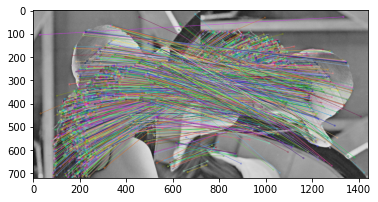

In [3]:
ratio = 0.5

#  计算匹配点匹配时间
start = time.time()

#  K近邻算法求取在空间中距离最近的K个数据点，并将这些数据点归为一类
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1, des2, k = 2)
good_matches = []
origin_pt = []
process_pt = []
for index, (m1, m2) in enumerate(raw_matches):
    #  如果最接近和次接近的比值大于一个既定的值，那么我们保留这个最接近的值，认为它和其匹配的点为good_match
    if m1.distance < ratio * m2.distance:
        good_matches.append([m1])
end = time.time()
print("匹配点匹配运行时间:%.2f秒"%(end-start))

matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, flags = 2)

plt.figure()
plt.imshow(matches)
plt.savefig('matches.png', dpi = 300)

# cs-FLTP

In [5]:
# def centroid(patch):
#     M0 = np.sum(patch)
#     M1 = 0
#     M2 = 0
#     for i  in range(3):
#         for j in range(3):
#             M1 += i*patch[i][j]
#     for i  in range(3):
#         for j in range(3):
#             M2 += j*patch[i][j]
#
#     return round(M1/M0), round(M2/M0)

def membership(patch, x, y, th1=5):
    gi = patch[x][y]
    gc = patch[1][1]
    gi_4 = patch[2-x][2-y]
    gm = min(abs(gi-gc), abs(gi_4-gc))
    return 1 - gm/th1

def S(a):
    if a>=0.95:
        return 2
    elif a>=0.5:
        return 1
    else:
        return 0

# def get_angle_index(angle):
#     if angle>=90.0 and angle<135:
#         return 0
#     elif angle>=135 and angle<180:
#         return 1
#     elif angle>=180 and angle<225:
#         return 2
#     elif angle>=225 and angle<270:
#         return 3
#     elif angle>=270 and angle<315:
#         return 4
#     elif angle>=325 and angle<360:
#         return 5
#     elif angle>=0 and angle<45:
#         return 6
#     else:
#         return 7

# def get_angle(x,y):
#     if np.arctan2(y,x) < 0:
#         return np.arctan2(y,x)/np.math.pi*180 + 360
#     else:
#         return np.arctan2(y,x)/np.math.pi*180


l = [(1,2),(0,2),(0,1),(0,0),(1,0),(2,0),(2,1),(2,2), (1,2)]

def g(patch, k=1):
    if k>8:
        return patch
    elif k%2==1:
        return g(patch, k+1)
    else:
        x, y = l[k-1]
        x2, y2 = l[k-2]
        x3, y3 = l[k]
        patch[x][y] = (1.5 - 2**0.5)*patch[1][1] + (2**0.5 -1)/2* (patch[x2][y2] + patch[x3][y3]) + 0.5 * patch[x][y]
        return g(patch, k+1)

def convert10to3(num):
    l = []
    while True:
        l.append(str(num%3))
        num //= 3
        if num==0:
            break
    l.reverse()
    return ''.join(l)

def convert3to10(num):
    num = num[::-1]
    sum = 0
    for i, n in enumerate(num):
        sum += int(n)*3**i
    return sum

def FLTP(patch):
    cs_fltp = 1000000
    num = []
    for x, y in l[:4]:
        patch = g(patch)
        a = membership(patch, x, y)
        num.append(S(a))
    cs_fltp1 = num
    cs_fltp2 = num[1:]+num[:1]
    cs_fltp3 = num[2:]+num[:2]
    cs_fltp4 = num[3:]+num[:3]
    s_a = [cs_fltp1,cs_fltp2,cs_fltp3,cs_fltp4]
    for cs_fltp_s in s_a:
        temp = 0
        for i, s in  enumerate(cs_fltp_s):
            temp += s*3**i
        cs_fltp = min(cs_fltp, temp)

    return cs_fltp

In [6]:
import numpy as np
a = np.array([[80,76, 66],
        [72,65,57],
        [64,55,45]])
g(a), FLTP(a)

(array([[72, 76, 66],
        [72, 65, 57],
        [63, 55, 56]]),
 1)

In [7]:
image1_pad = np.pad(image1, ((7,7),(7,7)))
image2_pad = np.pad(image2, ((7,7),(7,7)))

def get_weight(i,j,x=7,y=7,sigma=1.3):
    a = 1/(2*np.math.pi*sigma**2)
    e = np.math.e**(-((x-i)**2+(y-j)**2)/(2*sigma**2))
    return a*e

import cv2
from math import *
import numpy as np


def get_FLTP(image, kps):
    des_feature = []
    for kp in kps:
        fltps = []
        x,y = kp.pt
        x = round(x) + 7
        y = round(y) + 7
        patch = image[x-7:x+8,y-7:y+8]
        patch = patch[2:13,2:13]
        for i in range(1,10):
            for j in range(1,10):
                patch_ = patch[i-1:i+2,j-1:j+2]
                fltp = FLTP(patch_)
                weight = get_weight(i,j)
                fltps.append(fltp*weight)
        fltps_norm = np.linalg.norm(fltps)
        # fltps_norm = 1
        fea = np.array(fltps)/fltps_norm
        des_feature.append(fea)
    return des_feature

In [8]:
des1_ = get_FLTP(image1_pad, kp1)
des2_ = get_FLTP(image2_pad, kp2)
des1_ = np.array(des1_).astype('float32')
des2_ = np.array(des2_).astype('float32')

d:\program files\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
d:\program files\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in ubyte_scalars


匹配点匹配运行时间:0.05秒


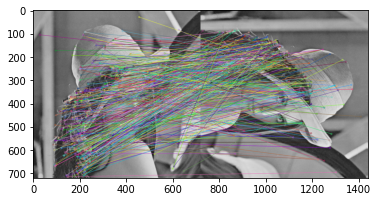

In [9]:

ratio = 0.8

#  计算匹配点匹配时间
start = time.time()

#  K近邻算法求取在空间中距离最近的K个数据点，并将这些数据点归为一类
matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1_, des2_, k = 2)
good_matches = []
origin_pt = []
process_pt = []
for index, (m1, m2) in enumerate(raw_matches):
    if m1.distance < ratio * m2.distance:
        good_matches.append([m1])
end = time.time()
print("匹配点匹配运行时间:%.2f秒"%(end-start))

matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, flags = 2)

plt.figure()
plt.imshow(matches)
plt.savefig('matches_.png', dpi = 300)


In [10]:
# 改变数组的表现形式，不改变数据内容，数据内容是每个关键点的坐标位置
src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# findHomography 函数是计算变换矩阵
# 参数cv2.RANSAC是使用RANSAC算法寻找一个最佳单应性矩阵H，即返回值M
# 返回值：M 为变换矩阵，mask是掩模
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
# ravel方法将数据降维处理，最后并转换成列表格式
matchesMask = mask.ravel().tolist()

kp1Pt = np.float32([kp.pt for kp in kp1]).reshape(-1,1,2)

# 计算变换后的四个顶点坐标位置
dst = cv2.perspectiveTransform(kp1Pt, M)




In [11]:
num = [0,2,0,0]
cs_fltp1 = num[0:]+num[:0]
cs_fltp2 = num[1:]+num[:1]
cs_fltp3 = num[2:]+num[:2]
cs_fltp4 = num[3:]+num[:3]
cs_fltp1,cs_fltp2,cs_fltp3,cs_fltp4


([0, 2, 0, 0], [2, 0, 0, 0], [0, 0, 0, 2], [0, 0, 2, 0])

In [ ]:
def s_ltp(patch, x, y):
    gi = patch[x][y]
    gc = patch[1][1]
    # gi_4 = patch[2-x][2-y]
    if gi-gc >5:
        return 2
    elif 5>=gi-gc>2:
        return 1
    else:
        return 0

def LTP(patch):
    cs_ltp = 0
    for i, (x, y) in enumerate(l[:4]):
        a = s_ltp(patch, x, y)
        cs_ltp += a*3**i
    return cs_ltp

def s_lbp(patch, x, y):
    gi = patch[x][y]
    gi_4 = patch[2-x][2-y]
    if gi-gi_4 > 5:
        return 1
    else:
        return 0

def LBP(patch):
    cs_lbp = 0
    for i, (x, y) in enumerate(l[:4]):
        a = s_lbp(patch, x, y)
        cs_lbp += a*2**i
    return cs_lbp